In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import torch.nn as nn
import torch.nn.functional as F
from single_task.NoDA_base.relu_models import FeatureExtractor, LabelRegressor

from jupyter_utils import AllDataset

data_dir = '../drp-data/'
GDSC_GENE_EXPRESSION = 'preprocessed/gdsc_tcga/gdsc_rma_gene_expr.csv'
TCGA_GENE_EXPRESSION = 'preprocessed/gdsc_tcga/tcga_log2_gene_expr.csv'

TCGA_TISSUE = 'preprocessed/tissue_type/TCGA_tissue_one_hot.csv'
GDSC_TISSUE = 'preprocessed/tissue_type/GDSC_tissue_one_hot.csv'

GDSC_lnIC50 = 'preprocessed/drug_response/gdsc_lnic50.csv'
TCGA_DR = 'preprocessed/drug_response/tcga_drug_response.csv'

dataset = AllDataset(data_dir, GDSC_GENE_EXPRESSION, TCGA_GENE_EXPRESSION, 
                     GDSC_lnIC50, TCGA_DR, TCGA_TISSUE)

In [2]:
drug = 'tamoxifen'
gdsc_expr, gdsc_dr, train_tcga_expr, test_tcga_expr = dataset.filter_and_normalize_data(drug)

In [3]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.random.set_seed(1)
from cxplain import CXPlain

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# exp = CXPlain.load('gene_finding/results/CX_ens1/%s/explainer'%drug, custom_model_loader=None, relpath=True)

In [5]:
drugs = [
    'bleomycin',
    'cisplatin',
    'cyclophosphamide',
    'docetaxel',
    'doxorubicin',
    'etoposide',
    'gemcitabine',
    'irinotecan',
    'oxaliplatin',
    'paclitaxel',
    'pemetrexed',
    'tamoxifen',
    'temozolomide',
    'vinorelbine']

In [6]:
attr_dict = {}
for i, drug in enumerate(drugs):
    print(drug)
    _, _, _, test_tcga_expr = dataset.filter_and_normalize_data(drug)
    exp = CXPlain.load('gene_finding/results/CX_ens1/%s/explainer'%drug, custom_model_loader=None, relpath=True)
    attr = exp.explain(test_tcga_expr.values)
    attr = pd.DataFrame(attr, index=test_tcga_expr.index, columns=dataset.hgnc)
    attr_dict[drug]=attr

bleomycin
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
cisplatin
cyclophosphamide
docetaxel
doxorubicin
etoposide
gemcitabine
irinotecan
oxaliplatin
paclitaxel
pemetrexed
tamoxifen
temozolomide
vinorelbine


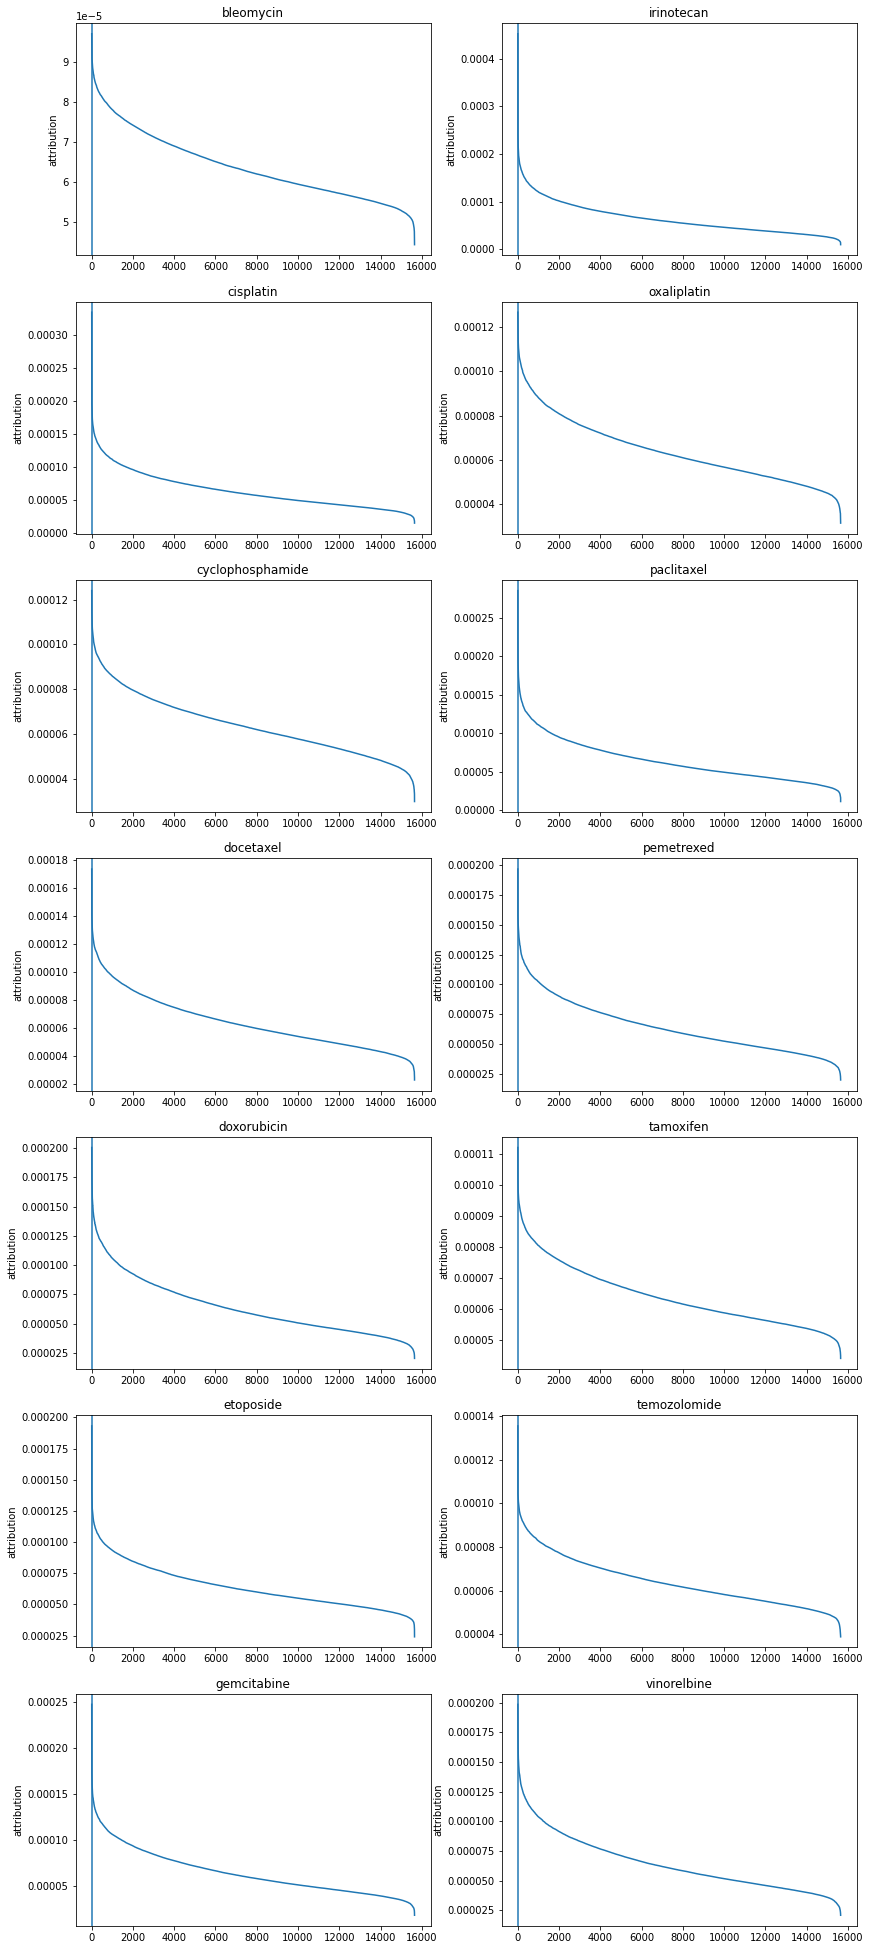

In [7]:
fig, axes = plt.subplots(7, 2, figsize=(14, 35))
for i, drug in enumerate(drugs):
    ax = axes[i%7][i//7]
    attr_drug = attr_dict[drug].mean(axis=0).sort_values(ascending=False)
    
    largest_slope = 0
    largest_slope_index = 0
    for y in range(len(dataset.hgnc)//2):
        slope = -(attr_drug[y+1] - attr_drug[y])
        if slope > largest_slope:
            largest_slope = slope
            largest_slope_index = y
    
    ax.plot(range(len(dataset.hgnc)), attr_drug)
    ax.set_title(drug)
    ax.set_ylabel('attribution')
    ax.axvline(largest_slope_index)
#     ax.set_xlabel('gene index')
plt.show()

In [8]:
def check_intersect(arr, thresh, min_, max_, less, greater):
    mid = (min_ + max_)//2
    
#     print(min_, max_, mid, arr[mid], thresh(mid), less, greater)
    if less and greater:
        return True
    elif min_ + 1 == max_:
        return False
    
    if arr[mid] > thresh(mid):
        return check_intersect(arr, thresh, min_, mid, less, True)
    else:
        return check_intersect(arr, thresh, mid, max_, True, greater)

3911 7.7106524e-05 7.7106524e-05


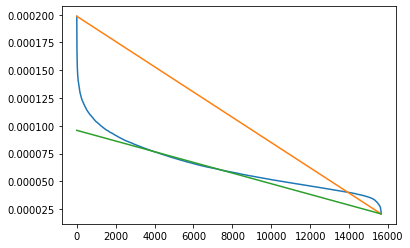

In [9]:
n_genes = len(dataset.hgnc)
x2 = n_genes - 1
y2 = attr_drug[x2]

fig, ax = plt.subplots()
ax.plot(range(n_genes), attr_drug)
for x1 in range(n_genes):
    y1 = attr_drug[x1]
    
    m = (y2 - y1)/(x2 - x1)    
    thresh = lambda x: m*(x - x1) + y1
    
    if x1 == 0:
        ax.plot([0, n_genes], [thresh(x1), y2])

    intersect = check_intersect(attr_drug, thresh, 0, n_genes-1, False, False)
    if not intersect:
        ax.plot([0, n_genes], [thresh(0), y2])
        print(x1, y1, attr_drug[x1])
        break

107 8.629182e-05 8.629182e-05
460 0.00012664562 0.00012664562
195 9.687931e-05 9.687931e-05
274 0.00011203105 0.00011203105
321 0.00012490235 0.00012490235
242 0.000108256136 0.000108256136
319 0.00012389147 0.00012389147
468 0.0001409343 0.0001409343
239 9.964547e-05 9.964547e-05
343 0.00013015413 0.00013015413
293 0.00011855179 0.00011855179
183 8.9641704e-05 8.9641704e-05
124 9.451085e-05 9.451085e-05
378 0.00011883413 0.00011883413


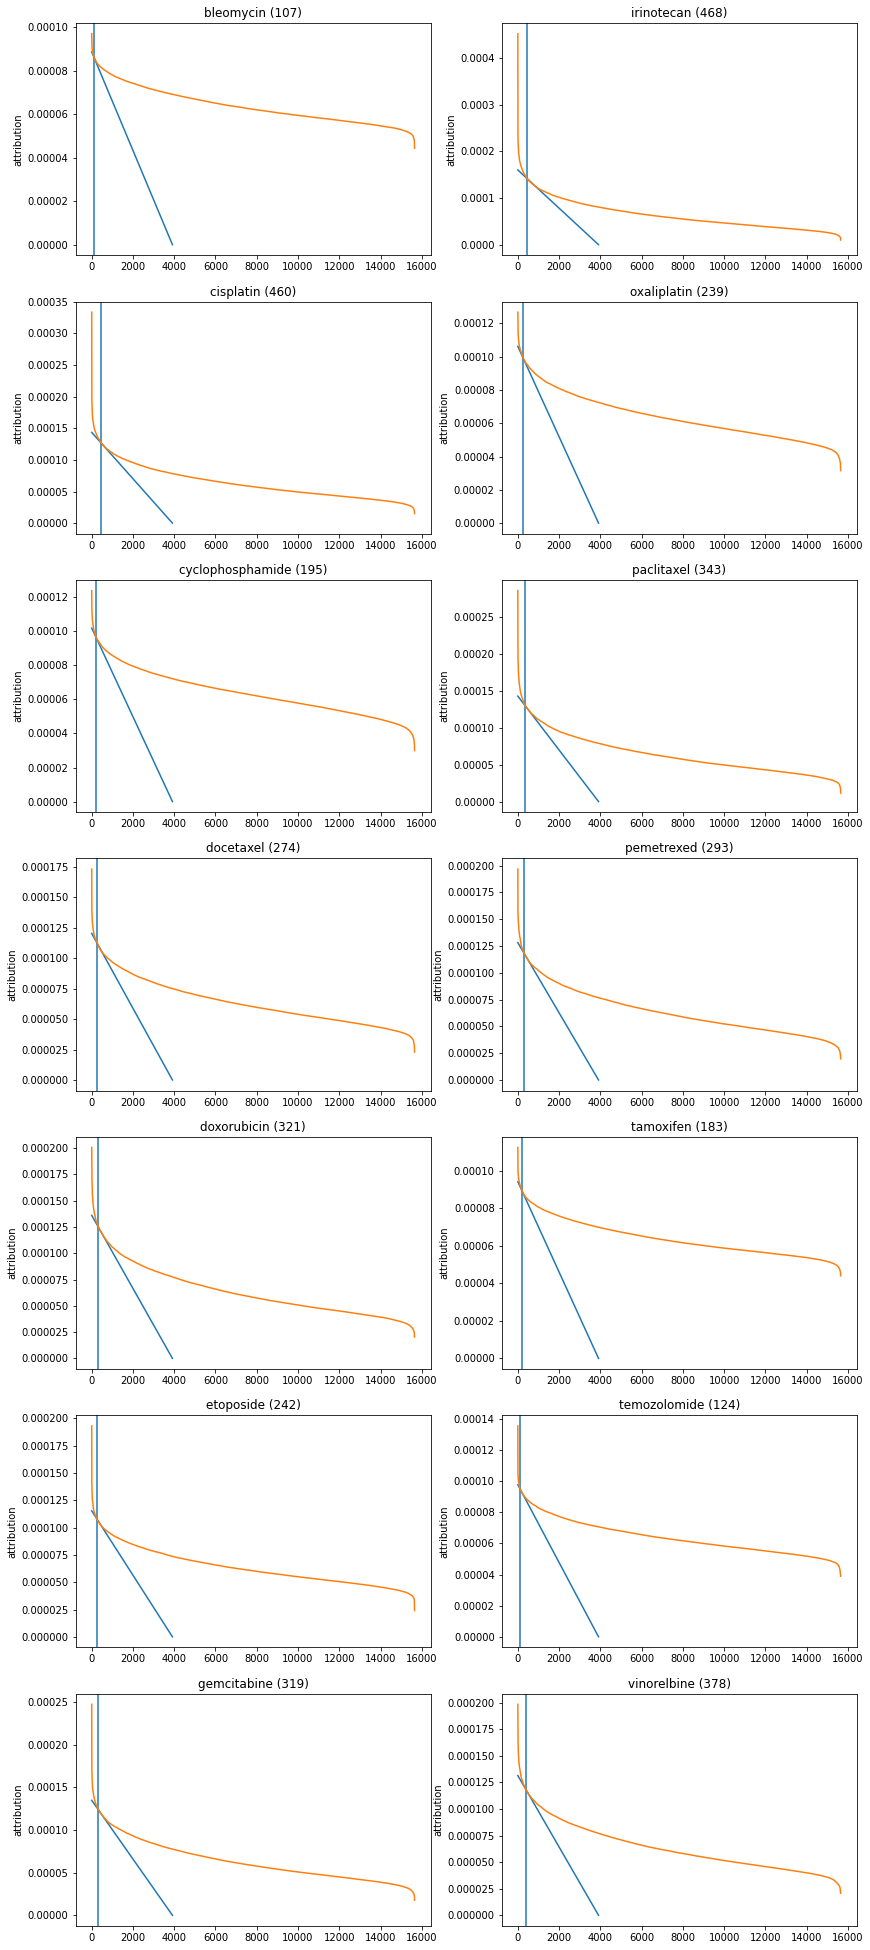

In [10]:
fig, axes = plt.subplots(7, 2, figsize=(14, 35))
n_genes = len(dataset.hgnc)
for i, drug in enumerate(drugs):
    ax = axes[i%7][i//7]
    attr_drug = attr_dict[drug].mean(axis=0).sort_values(ascending=False)
    
#     x2 = n_genes - 1
#     y2 = attr_drug[x2]
    x2 = n_genes//4
    y2=0
    for x1 in range(n_genes):
        y1 = attr_drug[x1]

        m = (y2 - y1)/(x2 - x1)    
        thresh = lambda x: m*(x - x1) + y1

        intersect = check_intersect(attr_drug, thresh, 0, n_genes-1, False, False)
        if not intersect:
            ax.plot([0, x2], [thresh(0), y2])
            print(x1, y1, attr_drug[x1])
            ax.axvline(x1)
            break
    
    
    
    ax.plot(range(n_genes), attr_drug)
    ax.set_title("%s (%d)"%(drug, x1))
    ax.set_ylabel('attribution')
#     ax.set_xlabel('gene index')
plt.show()

In [11]:
attr_drug = attr_dict['etoposide'].mean(axis=0).sort_values(ascending=False)

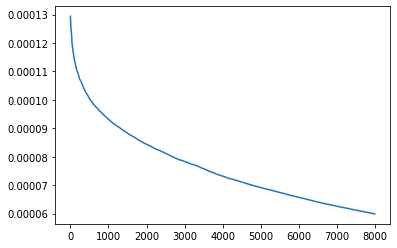

In [47]:
plt.plot(range(8000), attr_drug[20:8020])

In [103]:
from kneed import KneeLocator
kneedle = KneeLocator(np.arange(len(attr_drug)),attr_drug, curve='convex', direction='decreasing')

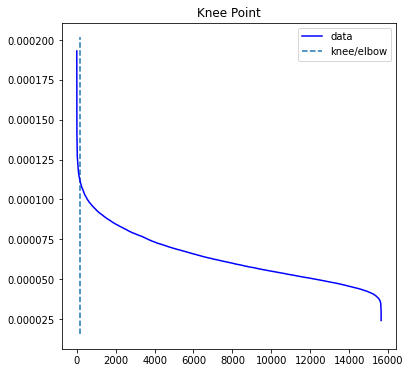

In [106]:
kneedle.plot_knee()

In [105]:
kneedle.knee

187

In [82]:
data = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8],  # linear until (8,8)
                 [9, 16], [10, 32], [11, 64], [12, 128], [13, 256], [14, 512]])   # exponential afterwards

4

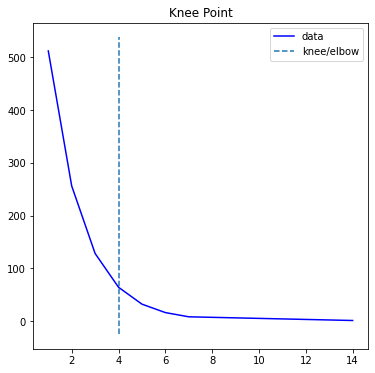

In [97]:
kneedle = KneeLocator(data[:,0],data[::-1][:,1], curve='convex', direction='decreasing')
kneedle.plot_knee()
kneedle.knee

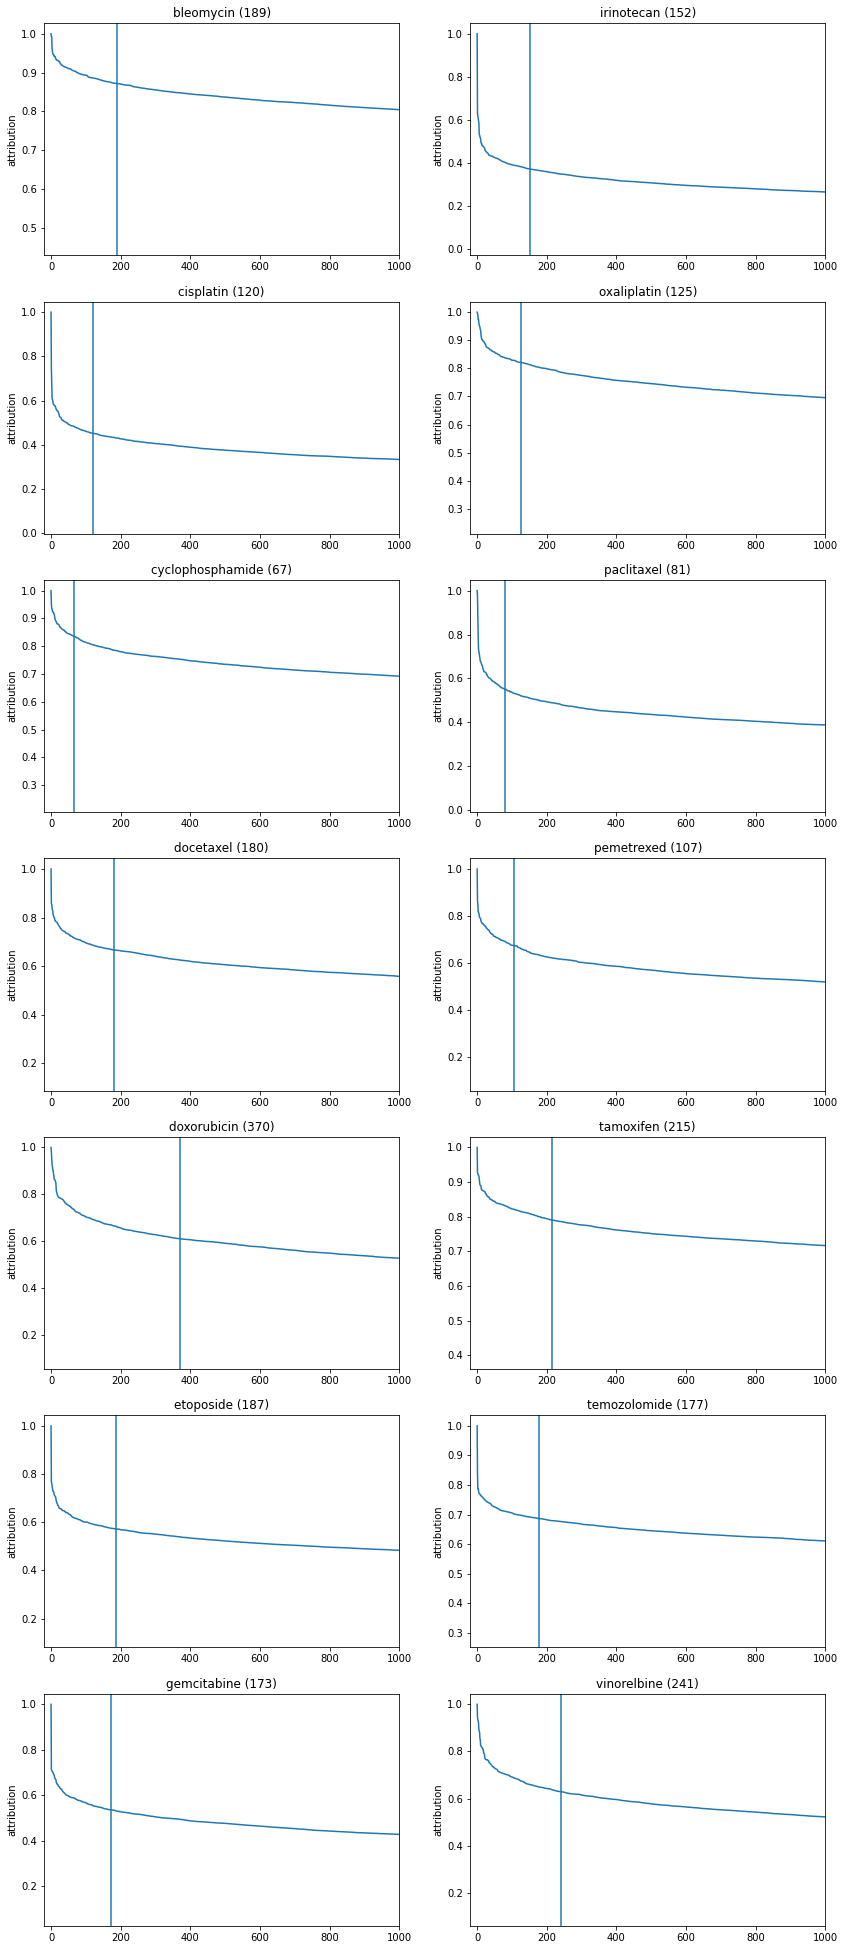

In [151]:
fig, axes = plt.subplots(7, 2, figsize=(14, 35))
for i, drug in enumerate(drugs):
    ax = axes[i%7][i//7]
    attr_drug = attr_dict[drug].mean(axis=0).sort_values(ascending=False)
    attr_drug = attr_drug/attr_drug.max()
    
    kneedle = KneeLocator(np.arange(len(attr_drug)),attr_drug, curve='convex', direction='decreasing')
    
    ax.plot(range(len(dataset.hgnc)), attr_drug)
    ax.set_title("%s (%d)"%(drug, kneedle.knee))
    ax.set_ylabel('attribution')
    ax.axvline(kneedle.knee)
    ax.set_xlim(left=-20, right=1000)
#     ax.set_xlabel('gene index')
# plt.savefig('kneedle_zoom.pdf')
plt.show()


In [114]:
def area(a, b, c):
    return np.abs((b[0]-a[0])*(c[1]-a[1]) - (b[1]-a[1])*(c[0]-a[0]))/2

def dist(a, b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

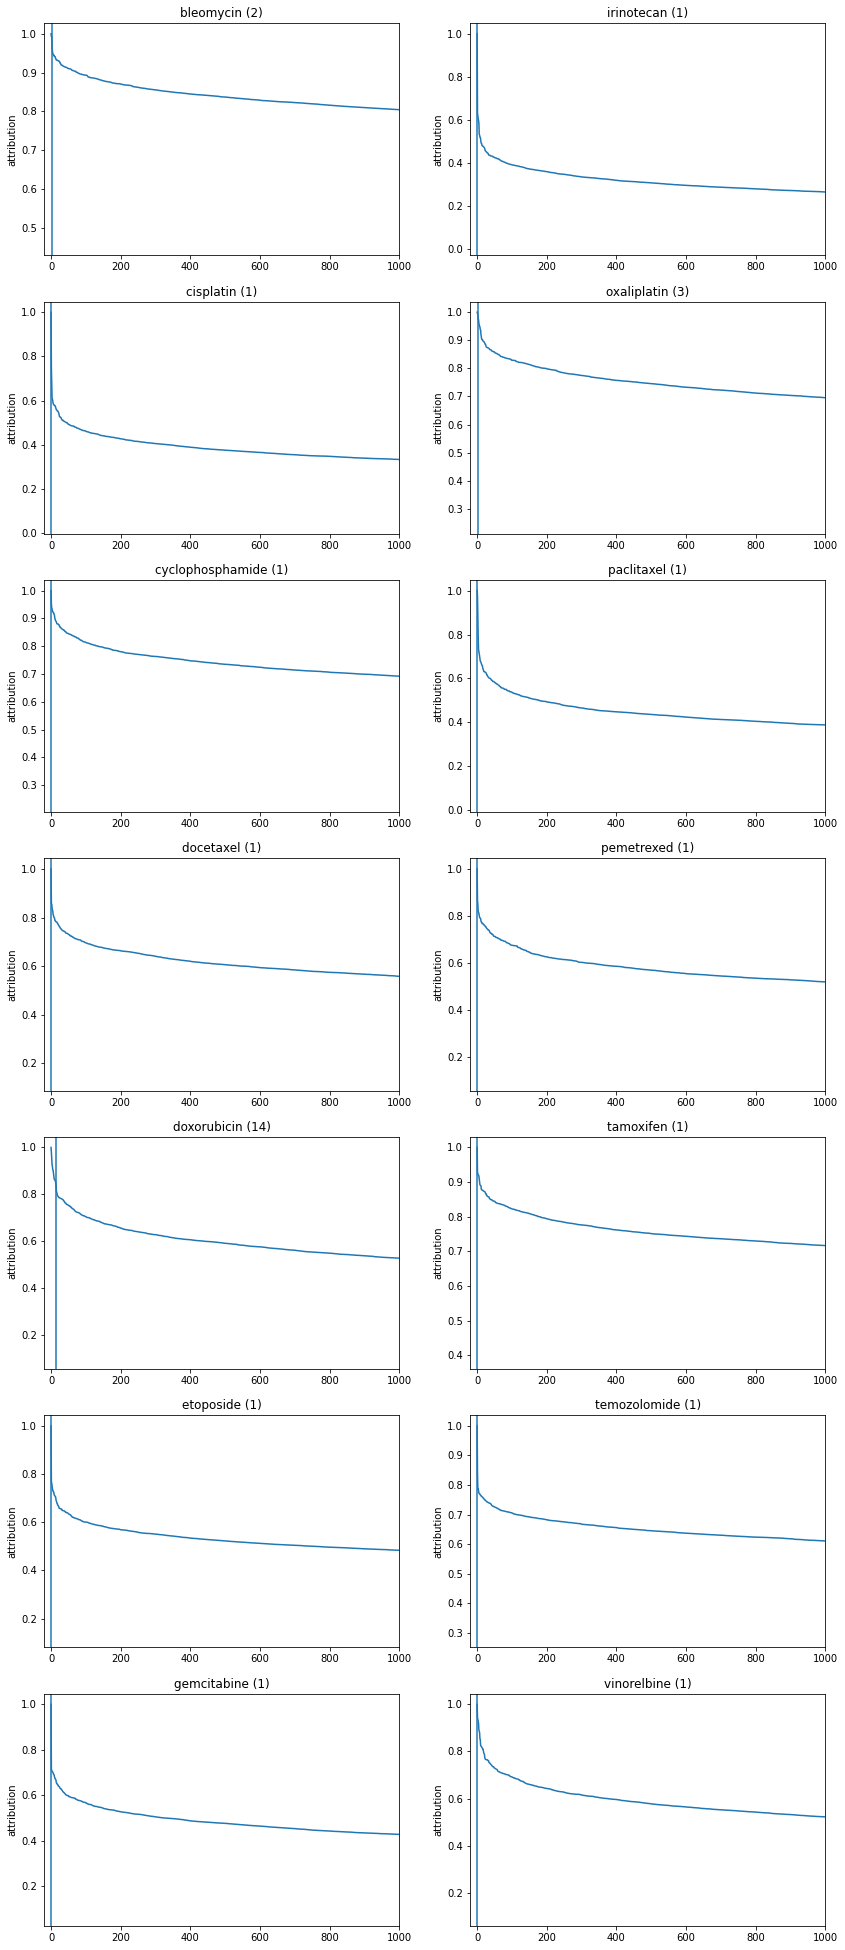

In [150]:
fig, axes = plt.subplots(7, 2, figsize=(14, 35))
for i, drug in enumerate(drugs):
    ax = axes[i%7][i//7]
    attr_drug = attr_dict[drug].mean(axis=0).sort_values(ascending=False)
    attr_drug = attr_drug/attr_drug.max()
    
    curvature = []
    for i in range(1,8000):
        a = [i-1, attr_drug[i-1]]
        b = [i, attr_drug[i]]
        c = [i+1, attr_drug[i+1]]
        curv = 4*area(a, b, c)/(dist(a,b)*dist(b,c)*dist(c,a))
        curvature.append(curv)
    
    thresh = np.argmax(curvature)+1
    ax.plot(range(len(dataset.hgnc)), attr_drug)
    ax.set_title("%s (%d)"%(drug, thresh))
    ax.set_ylabel('attribution')
    ax.axvline(thresh)
    ax.set_xlim(left=-20, right=1000)
#     ax.set_xlabel('gene index')
plt.show()

In [140]:
attr_drug = attr_dict['etoposide'].mean(axis=0).sort_values(ascending=False)
curvature = []
for i in range(1,1000):
    a = [i-1, attr_drug[i-1]]
    b = [i, attr_drug[i]]
    c = [i+1, attr_drug[i+1]]
    curv = 4*area(a, b, c)/(dist(a,b)*dist(b,c)*dist(c,a))
    curvature.append(curv)

0


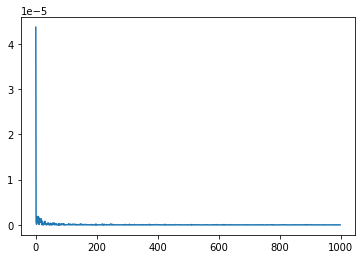

In [141]:
plt.plot(range(len(curvature)), curvature)
print(np.argmax(curvature))

In [130]:
a = [132, 532]
b = [275, 258]
c = [395, 267]
4*area(a, b, c)/(dist(a,b)*dist(b,c)*dist(c,a))

0.004921041222854115

In [134]:
def curvature(x_data, y_data):
    curvature = []
    for i in range(1, len(x_data) - 1):
        R = circumradius(x_data[i-1:i+2], y_data[i-1:i+2])
        if R == 0:
            print('failed')
            return 0
        curvature.append(1/R)
def circumradius(xvals, yvals):
    x1,x2,x3 = xvals
    y1,y2,y3 = yvals
    den = 2*((x2-x1)*(y3-y2)-(y2-y1)*(x3-x2))
    num =  ( (((x2-x1)**2) + ((y2-y1)**2)) * (((x3-x2)**2)+((y3-y2)**2)) * (((x1-x3)**2) +((y1-y3)**2)))**(0.5)
    if den == 0:
        print('failed2')
        return 0
    return np.abs(num/den)

In [138]:
1/circumradius([132,275,395], [532,258,267])

0.0049210412228541155

In [58]:
poly = np.polyfit(range(8000), attr_drug[:8000], deg=3)

In [29]:
poly

array([-1.97853265e-16,  3.16959745e-12, -1.95306716e-08,  1.12547544e-04])

In [30]:
p = lambda x: poly[0]*(x**3) + poly[1]*(x**2) + poly[2]*x + poly[3]
y = [p(x) for x in range(8000)]

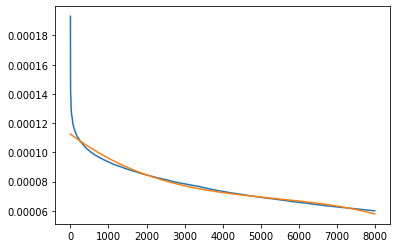

In [31]:
plt.plot(range(8000), attr_drug[:8000])
plt.plot(range(8000), y)

In [24]:
p(0)

0.00010739795811719652

In [ ]:
attr_drug[0]

In [20]:
attr_drug = attr_dict['etoposide'].mean(axis=0).sort_values(ascending=False)
largest_slope = 0
largest_slope_index = 0
smallest_slope = 10000
smallest_slope_idx = 0
slopes = np.zeros(len(dataset.hgnc)//2)
for y in range(len(dataset.hgnc)//2):
    slope = -(attr_drug[y+1] - attr_drug[y])
    if slope > largest_slope:
        largest_slope = slope
        largest_slope_index = y
    if slope < smallest_slope:
        smallest_slope = slope
        smallest_slope_index = y
    slopes[y] = slope

(-2.2423144400818276e-06, 1e-05)

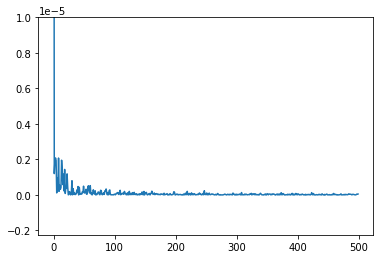

In [26]:
plt.plot(range(500), slopes[:500])
plt.ylim(top=1e-5)

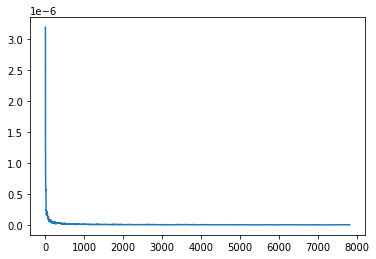

In [27]:
mav = np.zeros(slopes.shape)
for i in range(len(slopes)):
    mav[i] = slopes[i:i+20].mean()
plt.plot(range(len(mav)), mav)
# plt.ylim(top=80)

(array([4.530e+02, 6.408e+03, 5.096e+03, 2.541e+03, 9.150e+02, 2.040e+02,
        2.800e+01, 4.000e+00, 0.000e+00, 1.000e+00]),
 array([2.4042236e-05, 4.0952105e-05, 5.7861977e-05, 7.4771844e-05,
        9.1681715e-05, 1.0859159e-04, 1.2550145e-04, 1.4241133e-04,
        1.5932119e-04, 1.7623107e-04, 1.9314094e-04], dtype=float32),
 <BarContainer object of 10 artists>)

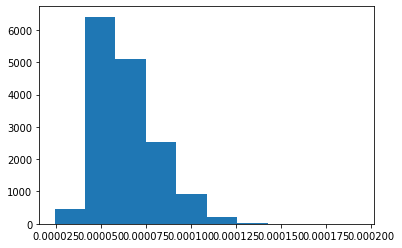

In [18]:
plt.hist(attr_drug)

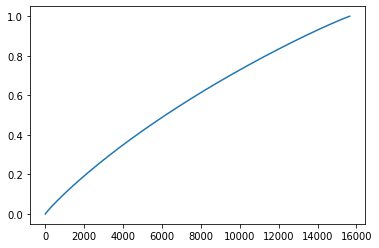

In [19]:
tot = np.zeros(len(attr_drug))
tot[0] = attr_drug[0]
for i in range(len(attr_drug)):
    tot[i] = tot[i-1]+attr_drug[i]
plt.plot(range(len(tot)), tot)

In [ ]:
tot[0]

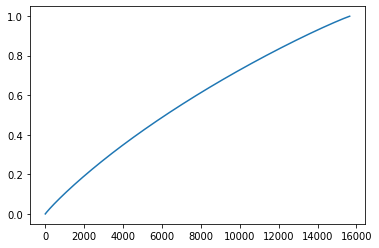

In [43]:
tot = np.zeros(len(attr_drug))
# tot[0] = attr_drug[0]
for i in range(len(attr_drug)):
    tot[i] = tot[i-1] + attr_drug[i:i+20].mean()
plt.plot(range(len(tot)), tot)

In [42]:
attr_drug[0:10].mean()

0.00014767973

In [41]:
tot[0]

0.00014767973334528506

In [32]:
mav[0]

3.187281981809065e-06